<a href="https://colab.research.google.com/github/Bovi-analytics/scheurwater-et-al-2021/blob/main/Peak_detection_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for the algorithm

This is a Google Colab Notebook. It has a google machine in the back which will activate the moment you click the play button from the first cell. You can run cells seperately, or all after eachother, it allows you to prototype much easier then using the PyCharm.

The notebook can be shared and editted by multiple people. If you want to work in your own version, you can make a copy of the notebook first.

#GDrive
You need to make a link with the data. This is all stored in your google drive , or in the case of this notebook a bovi-analytics folder.

First run the cell underneath, then open the link in the output and copy the code underneath. That way, the Google Drive is connected.

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


# Import libraries

In [ ]:
#import general libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import iqr
from scipy.stats import mode
from scipy.signal import welch
from scipy.fftpack import fft
from scipy import signal

In [ ]:
from sklearn import metrics 
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.utils import resample



/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Set directories

In [ ]:
#define directories
base_dir = '/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog'
output_dir = '/data/out/'
input_dir = '/data/in/traintest/picologs/'
video_dir= '/data/in/traintest/videos/'
output_path = base_dir + output_dir
input_path = base_dir + input_dir
video_path = base_dir + video_dir


In [ ]:
#create output directory
if os.path.isdir ( output_path ):
    pass
else:
    os.mkdir (output_path )

In [ ]:
#remove old output file
for f in os.listdir(output_path):
    print('Existing file : ' + f)
    oldfile = output_path + f
    if os.path.isfile(oldfile):
        os.remove(oldfile)
        print('Removed : ' + oldfile)
    else:
        pass
        print('Did not remove : ' + oldfile)

Existing file : ylva
Did not remove : /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/ylva
Existing file : processed_raw_data_pico_20190412_2_0708.csv
Removed : /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190412_2_0708.csv
Existing file : processed_raw_data_pico_20190415_0708.csv
Removed : /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190415_0708.csv
Existing file : processed_raw_data_pico_20190412_1_0708.csv
Removed : /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190412_1_0708.csv
Existing file : processed_raw_data_pico_20190411_1_0708.csv
Removed : /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190411_1_0708.csv
Existing file : processed_raw_

# Peak_detection_algorithm

## Algorithm function

In [ ]:
def picoalgorithm_gain(data, gain_peakdetection = 9,col=0):
    #data window paramters, 0,5s per sample
    start = 1
    Data = 0
    Rumination = 0
    PeakValue = 0
    PressureDetected = 0
    LowTimeCounterHold = 0

    #peak detection parameters
    Slope_Rise = 2 * gain_peakdetection;
    Slope_Fall = gain_peakdetection;
    Actual_Rise = float(0)
    Actual_Fall = float(0)

    #rumination detection parameters
    State = 1
    Timer_D = 0
    Timer_E = 0
    Timer_F = 0
    Pulse_High_flank = 0
    Rumination_Time = 10  # 0,5s samplerate -> 5s
    D = 10  # 0,5s samplerate -> 5s
    E = 30  # 0,5s samplerate -> 15s
    F = 10  # 0,5s samplerate -> 5s
    Pulse_detected = 0
    Pulse_detected_old = 0

    #low time parameters
    Lowtime_counter = 0

    #moving average filter
    MA_Filter = 0
    Baseline = 0
    Windowsize = 150
    Highest_peak = 0

    #high pressure detection parameters
    High_Pressure_level = 3500

    #loop for pulse detection
    for i in range(1,np.size(data[:, col])):
        Actual_Rise = data[i - 8, col] - data[i - 5, col]
        Actual_Fall = data[i - 8, col] - data[i - 10, col]

        #measure highest peak
        if ((data[i, col] - Baseline) > Highest_peak and i > (Windowsize + 10)):
            Highest_peak = (data[i, col] - Baseline)

        #calculating moving average filter
        MA_Filter = 0
        if i > Windowsize:
            for j in range(1, Windowsize):
                MA_Filter = MA_Filter + data[i - j, col]
            Baseline = int(MA_Filter / Windowsize)
            data[i, 5] = Baseline

        #high pressure level detection
        if ((data[i, col] - Baseline) > High_Pressure_level):
            data[i, 8] = 1000

        Pulse_detected = 0
        if Actual_Rise >= Slope_Rise and Actual_Fall >= Slope_Fall:
            Pulse_detected = 1

        #flank detection
        if Pulse_detected_old == 0 and Pulse_detected == 1:
            Pulse_High_flank = 1
        Pulse_detected_old = Pulse_detected
        Pulse_detected = 0
        data[i, 1] = Pulse_High_flank
        data[i, 2] = State
        data[i, 4] = LowTimeCounterHold

        if State == 1:  #wait for minimal low time
            if Timer_D >= D:
                State = 2
                Lowtime_counter = 0
                Highest_peak = 0

            if Pulse_High_flank == 1:
                State = 1
                Timer_D = 0
                Pulse_High_flank = 0

        elif State == 2:  #wait for first pulse
            if Pulse_High_flank == 1:
                State = 3
                Timer_E = 0;
                PulsLowTime = 0
                Pulse_High_flank = 0

        elif State == 3:  #wait for second pulse
            if Timer_E == E:
                State = 1
                Timer_D = 0
            if Pulse_High_flank == 1:
                Timer_F = 0;
                Pulse_High_flank = 0
                if Timer_E >= Rumination_Time:
                    State = 5
                    Timer_F = 0;
                else:
                    State = 4
                    Timer_F = 0;

        elif State == 4:  #wait for third pulse or minimal low time
            if Timer_F == F:
                State = 1
                Timer_D = 0
                #normal wave detected
                LowTimeCounterHold = Lowtime_counter/2
                data[i, 3] = 1
                data[i, 6] = Highest_peak
                Rumination = 0
                PeakValue = Highest_peak
            if Pulse_High_flank == 1:
                State = 5
                Pulse_High_flank = 0

        elif State == 5:  #wait for third pulse or minimal low time
            if Timer_F == F:
                State = 1
                Timer_D = 0
                #rumination wave detected
                LowTimeCounterHold = Lowtime_counter/2
                data[i, 3] = 2
                data[i, 6] = Highest_peak
                Rumination = 1
                PeakValue = Highest_peak
            if Pulse_High_flank == 1:
                if Timer_E <= E:  # pulse detected within window E
                    State == 5
                    Pulse_High_flank = 0
                else:
                    State = 1
                    Timer_D = 0
                    Pulse_High_flank = 0
                    # Error, no wave detected

        #loop timers 0,5s per loop
        Timer_D += 1
        Timer_F += 1
        Timer_E += 1
        Lowtime_counter += 1

        #database output
        data[i, 9] = Rumination
        data[i, 7] = PeakValue
    return data


## File processing function

The next algorythm allows

*   Fixed gain of 9
*   Allow flexible seperator
*   Allow display/store



In [ ]:
def process_file(file, base_directory, input_directory, output_directory, sep = ",", store = True, disp = False, gain = 9, col=0):
  infile = base_directory + input_directory + file
  outfile = base_directory + output_directory + 'processed_' + file
  
  #read the file and make sure to change NaN with 0.0
  raw_df = pd.read_csv (infile, sep, decimal=".", dtype={'datetime':str})
  raw_df['datetime'] = raw_df['datetime'].str.replace('T', ' ', case = False)
  raw_df['datetime'] = raw_df['datetime'].str.replace('\+02:00', '', case = False)
  raw_df['datetime'] = raw_df['datetime'].str.replace('\+01:00', '', case = False) 
  raw_df['datetime']=pd.to_datetime(raw_df['datetime'],format="%Y-%m-%d %H:%M:%S")
 
  raw_col = raw_df[['pressure']].fillna(0)
  raw_index = raw_df[['datetime']]
  raw_pressure = raw_df[['pressure']]
 
  #explicitely change format to int
  raw_col.pressure = raw_col.pressure.astype(float)
  
  #add extra columns with all 0.0 values
  extra_col_df = raw_col.assign(
    pulse_flank = 0.0, 
    state = 0.0, 
    wave_type = 0.0, 
    low_time= 0.0,
    baseline= 0.0,
    highest_peak= 0.0,
    moo= 0.0, 
    high_pressure= 0.0,
    time_start= 0.0,
    time_stop= 0.0,
    rumination= 0.0,
    peakvalue= 0.0)

  #create numpy array from pandas
  input_array = extra_col_df.to_numpy()
  index_array = raw_index.to_numpy()
  raw_pressure_array = raw_pressure.to_numpy()

  #run picoalgorithm and display result
  result = picoalgorithm_gain(input_array, gain, col)

  #create dataframe from result array
  dataset = pd.DataFrame({
    'datetime': index_array[:,0],
    'raw_pressure': result[:, 0],
    'ret_pressure': result[:, 0],
    'pulse_flank': result[:, 1], 
    'state': result[:, 2],
    'wave_type': result[:, 3],
    'low_time': result[:, 4],
    'baseline': result[:, 5],
    'highest_peak': result[:, 6],
    'peakvalue': result[:, 7],
    'high_pressure': result[:, 8],
    'rumination': result[:, 9]})
  
  #store to csv
  if store == True:
    dataset.to_csv(outfile)
  if disp == True:
    #display(dataset.head(1000))
    dataset.describe()

## Read input files and creat algorithm output file

In [ ]:
#load all files in directory with *.csv
pd.set_option('display.max_rows', None)

for f in os.listdir (input_path):
    if f.endswith ('.csv'):
        print("Started processing: " + f)
        process_file(f, base_dir, input_dir, output_dir, sep=",", store=True, disp=True, gain= 9, col=0)
        print("Done processing: " + f)

Started processing: raw_data_pico_20190415_0708.csv
Done processing: raw_data_pico_20190415_0708.csv
Started processing: raw_data_pico_20190412_2_0708.csv
Done processing: raw_data_pico_20190412_2_0708.csv
Started processing: raw_data_pico_20190412_1_0708.csv
Done processing: raw_data_pico_20190412_1_0708.csv
Started processing: raw_data_pico_20190411_1_0708.csv
Done processing: raw_data_pico_20190411_1_0708.csv
Started processing: raw_data_pico_20190411_2_0708.csv
Done processing: raw_data_pico_20190411_2_0708.csv
Started processing: raw_data_pico_20190405_2_0708.csv
Done processing: raw_data_pico_20190405_2_0708.csv
Started processing: raw_data_pico_20190405_1_0708.csv
Done processing: raw_data_pico_20190405_1_0708.csv
Started processing: raw_data_pico_20190403_2_0708.csv
Done processing: raw_data_pico_20190403_2_0708.csv
Started processing: raw_data_pico_20190403_1_0708.csv
Done processing: raw_data_pico_20190403_1_0708.csv
Started processing: raw_data_pico_20190305_0708.csv
Done pr

In [ ]:
#create list of processed files
processed_dir = output_path
all_files = glob.glob(processed_dir + "*.csv")

li = []

for filename in all_files:
    print(filename)
    df = pd.read_csv(filename, index_col=0, header=0, sep = ",", decimal=".", dtype={'datetime':str}, parse_dates=['datetime']
    )
    df['datetime']=pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S")
    print(type(df['datetime']))
    df['file'] = filename
    li.append(df)

df_concat_processed = pd.concat(li, axis=0, ignore_index=True)

#create column "rumination_alg"
df_concat_processed['rumination_alg'] = df_concat_processed['rumination'].apply(lambda x: 1 if x == 1.0 else 0)

/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190412_2_0708.csv
<class 'pandas.core.series.Series'>
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190415_0708.csv
<class 'pandas.core.series.Series'>
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190412_1_0708.csv
<class 'pandas.core.series.Series'>
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190411_1_0708.csv
<class 'pandas.core.series.Series'>
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190411_2_0708.csv
<class 'pandas.core.series.Series'>
/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/processed_raw_data_pico_20190405

## Read input files and creat video output file

In [ ]:
path_video = video_path
all_files = glob.glob(path_video + "*.csv")
li = []
for filename in all_files:
    print("Started processing: " + filename)
    df = pd.read_csv(filename, 
                    header=0, 
                    sep = ";", 
                    decimal=".", 
                    nrows = 25000, 
                    skipinitialspace=True, 
                    dtype={'datetime':str, 'code_1_5':float,'code_6_or_12':float,'code_15':float,'other_1':float, 'other_2': float}, parse_dates=['datetime']
                    )[['cow_number', 'datetime', 'code_1_5', 'code_6_or_12', 'code_15', 'other_1','other_2']].dropna()
    df['datetime']=pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S")
    df.dtypes
    #create a seperate column for each behaviour
    df['rumination_video'] = df['code_1_5'].apply(lambda x: 1 if x == 1.0 else 0)
    df['other_video'] = df['code_1_5'].apply(lambda x: 5 if x == 2.0 else 0)
    df['drinking_video'] = df['code_1_5'].apply(lambda x: 3 if x ==5.0 else 0)
    df['sleeping_video']=df['code_1_5'].apply(lambda x: 4 if x == 3.0 else 0)
    df['eating_video']=df['code_1_5'].apply(lambda x: 2 if x == 4.0 else 0)
    df['behaviour']=df['rumination_video']+df['eating_video']+df['drinking_video']+df['sleeping_video']+df['other_video']
    li.append(df)
    print("Done processing: " + filename)
#create a panda dataframe of processed video files
df_concat_video = pd.concat(li, axis=0, ignore_index=True)

Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k13_20190412_1108.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k13_20190412_1108.csv
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k21_20190218_1108.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k21_20190218_1108.csv
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k21_20190205_1108.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k21_20190205_1108.csv
S

## Merge processsed files and video files

In [ ]:
df_inner_merged = pd.merge(df_concat_processed, df_concat_video, on='datetime', how='inner')

In [ ]:
final_data_peak_detection=df_inner_merged

In [ ]:
#remove data with pressure signal error, labeled "code_15"
final_data_peak_detection_corrected = final_data_peak_detection[final_data_peak_detection.code_15 != 15]

## Confusion matrix and classification report

In [ ]:
results = confusion_matrix(final_data_peak_detection_corrected['rumination_video'], final_data_peak_detection_corrected['rumination_alg'])

print('Confusion matrix peak_detection_algorithm for rumination:')
print(results) 
print('Accuracy Score : ', accuracy_score(final_data_peak_detection_corrected['rumination_video'], final_data_peak_detection_corrected['rumination_alg']))
print('Report : ')
print(classification_report(final_data_peak_detection_corrected['rumination_video'], final_data_peak_detection_corrected['rumination_alg']))

Confusion matrix peak_detection_algorithm for rumination:
[[243710  27374]
 [  3799 127643]]
Accuracy Score :  0.9225565553529461
Report : 
              precision    recall  f1-score   support

           0       0.98      0.90      0.94    271084
           1       0.82      0.97      0.89    131442

    accuracy                           0.92    402526
   macro avg       0.90      0.94      0.92    402526
weighted avg       0.93      0.92      0.92    402526



# Random_forest_algorithm

## Features

In [ ]:
def preprocess_feature_file(file, sep = ","):
  #read the file and make sure to change NaN with 0.0
  pressure_df = pd.read_csv(file, sep, decimal=".").dropna()
  # normalisation
  pressure_df["pressure"] /= np.max(np.abs(pressure_df["pressure"].values),axis=0)
  # define columns
  pressure_df["datetime"] = pressure_df["datetime"].astype(str).str[:-6].str.replace('T', ' ', regex=False).astype(str)
  pressure_df["file_index"] = pressure_df.index
  pressure_df["feature_filename"] = file
  return pressure_df

In [ ]:
all_feature_files = glob.glob(input_path + "*.csv")
list_feature_df = []
for filename in all_feature_files:
    print("Started processing: " + filename)
    df = preprocess_feature_file(filename, sep=",")
    list_feature_df.append(df)
    print("Done processing")

Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/picologs/raw_data_pico_20190415_0708.csv
Done processing
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/picologs/raw_data_pico_20190412_2_0708.csv
Done processing
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/picologs/raw_data_pico_20190412_1_0708.csv
Done processing
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/picologs/raw_data_pico_20190411_1_0708.csv
Done processing
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/picologs/raw_data_pico_20190411_2_0708.csv
Done processing
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwa

In [ ]:
df_concat_features = pd.concat(list_feature_df, axis=0, ignore_index=True)

## Labels

In [ ]:
WIN_SIZE = 240
WIN_OVERLAP = 1
BEHAVIOUR_1= 'rumination_video'
BEHAVIOUR_2= 'eating_video'
BEHAVIOUR_3= 'drinking_video'
BEHAVIOUR_4= 'sleeping_video'

In [ ]:
def preprocess_label_file(file, window_size):
    # read the file
    df_raw = pd.read_csv(file, header=0, sep = ";", decimal=".", nrows = 25000)[['cow_number', 'datetime','code_1_5', 'code_6_or_12', 'code_15', 'other_1','other_2']].dropna()
    # make a copy without ' ' in specific code
    df=df_raw
    # make extra columns
    df['rumination_video'] = df['code_1_5'].apply(lambda x: 1 if x == 1.0 else 0)
    df['eating_video'] = df['code_1_5'].apply(lambda x: 1 if x == 4.0 else 0)
    df['resting_video'] = df['code_1_5'].apply(lambda x: 1 if x == 2.0 else 0)
    df['sleeping_video'] = df['code_1_5'].apply(lambda x: 1 if x == 3.0 else 0)
    df['drinking_video'] = df['code_1_5'].apply(lambda x: 1 if x == 5.0 else 0)
    #create one colum for behaviour
    df_beh= df
    df_beh["eating_video"].replace({1:2}, inplace= True)
    df_beh["drinking_video"].replace({1:3}, inplace= True)
    df_beh["sleeping_video"].replace({1:4}, inplace= True)
    df_beh["resting_video"].replace({1:5}, inplace= True)
    df['behaviour']=df_beh['rumination_video']+df_beh['eating_video']+df_beh['resting_video']+df_beh['drinking_video']+df_beh['sleeping_video']
    # most frequent behaviour in time frame
    df['label_filename'] = file
    df['code_1_5'] = df['code_1_5'].astype(str)
    df['rolling_behaviour_backward'] = df.code_1_5.rolling(window = window_size, min_periods=0).apply(lambda x: mode(x)[0])
    df['rolling_rumination_backward'] = df['rolling_behaviour_backward'].apply(lambda x: 1 if x == 1.0 else 0)
    df['rolling_eating_backward'] = df['rolling_behaviour_backward'].apply(lambda x: 1 if x == 4.0 else 0)
    df['rolling_resting_backward'] = df['rolling_behaviour_backward'].apply(lambda x: 1 if x == 2.0 else 0)
    df['rolling_sleeping_backward'] = df['rolling_behaviour_backward'].apply(lambda x: 1 if x == 3.0 else 0)
    df['rolling_drinking_backward'] = df['rolling_behaviour_backward'].apply(lambda x: 1 if x == 5.0 else 0)
    # behaviour existing in time frame
    df['was_ruminating_backward'] = df.code_1_5.rolling(window = window_size, min_periods=0).apply(lambda x:1 if 1.0 in x else 0)
    df['was_eating_backward'] = df.code_1_5.rolling(window = window_size, min_periods=0).apply(lambda x:1 if 4.0 in x else 0)
    df['was_resting_backward'] = df.code_1_5.rolling(window = window_size, min_periods=0).apply(lambda x:1 if 2.0 in x else 0)
    df['was_sleeping_backward'] = df.code_1_5.rolling(window = window_size, min_periods=0).apply(lambda x:1 if 3.0 in x else 0) 
    df['was_drinking_backward'] = df.code_1_5.rolling(window = window_size, min_periods=0).apply(lambda x:1 if 5.0 in x else 0)
    return df

In [ ]:
all_label_files = glob.glob(video_path + "*.csv")
list_label_df = []
for filename in all_label_files:
  print("Started processing: " + filename)
  df = preprocess_label_file(filename, WIN_SIZE)
  list_label_df.append(df)
  print("Done processing: " + filename)

Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k13_20190412_1108.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k13_20190412_1108.csv
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k21_20190218_1108.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k21_20190218_1108.csv
Started processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k21_20190205_1108.csv
Done processing: /content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/in/traintest/videos/raw_data_video_k21_20190205_1108.csv
S

In [ ]:
df_concat_labels = pd.concat(list_label_df, axis=0, ignore_index=True)

## Merge

In [ ]:
df_merged = pd.merge(df_concat_features, df_concat_labels, on='datetime', how='inner')

In [ ]:
final_data_rf=df_merged

Adopted from https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442

## Sliding windows

In [ ]:
def np_ffill(arr, axis):
    idx_shape = tuple([slice(None)] + [np.newaxis] * (len(arr.shape) - axis - 1))
    idx = np.where(~np.isnan(arr), np.arange(arr.shape[axis])[idx_shape], 0)
    np.maximum.accumulate(idx, axis=axis, out=idx)
    slc = [np.arange(k)[tuple([slice(None) if dim==i else np.newaxis
        for dim in range(len(arr.shape))])]
        for i, k in enumerate(arr.shape)]
    slc[axis] = idx
    return arr[tuple(slc)]

In [ ]:
def extract_sliding_windows(df, label_col_1, label_col_2, label_col_3, label_col_4, pressure_col,  id_col, sub_window_size, chopped):
    series = []
    max_time = len(df)
    pressure_index = df.columns.get_loc(pressure_col)
    for i in range(max_time-sub_window_size+1):
      if df["file_index"][i] % chopped == 0.0:
        serie = df[pressure_col][i:sub_window_size+i-1].values
        forward_serie = np_ffill(serie, 0)
        backfill_serie = np_ffill(forward_serie[::-1], 0)[::-1]
        id_arr = df[id_col][i:sub_window_size+i-1].values
        id =  id_arr[::-1][0]
        label_arr_1 = df[label_col_1][i:sub_window_size+i-1].values        
        label_1 = label_arr_1[::-1][0]        
        label_arr_2 = df[label_col_2][i:sub_window_size+i-1].values        
        label_2 = label_arr_2[::-1][0]
        label_arr_3 = df[label_col_3][i:sub_window_size+i-1].values        
        label_3 = label_arr_3[::-1][0]
        label_arr_4 = df[label_col_4][i:sub_window_size+i-1].values        
        label_4 = label_arr_4[::-1][0]
        series.append((id, label_1, label_2, label_3, label_4, backfill_serie))
    return np.vstack(series)

In [ ]:
result_np = extract_sliding_windows(df_merged, BEHAVIOUR_1, BEHAVIOUR_2, BEHAVIOUR_3, BEHAVIOUR_4, "pressure", "cow_number",WIN_SIZE, WIN_OVERLAP)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## Signal processing

Adopted from http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

Thank you Marcos Duarte

In [ ]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

In [ ]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [(1/f_s) * kk for kk in range(0,len(y_values))]
    return x_values, y_values

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values
    
def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y


In [ ]:
def extract_features(dataset, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    for signal_no in range(0, len(dataset)):
      if signal_no % 10000 == 0.0:
        print(signal_no)
      features = []
      id = dataset[signal_no, 0]      
      label_1 = dataset[signal_no,1]
      label_2 = dataset[signal_no,2]
      label_3 = dataset[signal_no,3]
      label_4 = dataset[signal_no,4]
      signal = dataset[signal_no,5]
      signal_min = np.nanpercentile(signal, percentile)
      signal_max = np.nanpercentile(signal, 100-percentile)
      mph = (signal_min + (signal_max - signal_min))/denominator     
      #create features
      features += get_features(*get_psd_values(signal, T, N, f_s), mph)
      features += get_features(*get_fft_values(signal, T, N, f_s), mph)
      features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
      list_of_features.append((label_1, label_2, label_3, label_4, id, features))
    return np.vstack(list_of_features)

In [ ]:
  N = WIN_SIZE #samples
  f_s = 2 #frequency
  t_n = 0.5*N
  T = t_n / N
  sample_rate = 1 / f_s
  denominator = 1000

In [ ]:
signal_features = extract_features(result_np, T, N, f_s, denominator)

0


/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 239, using nperseg = 239
  .format(nperseg, input_length))


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
X_final = np.stack(signal_features[:,5], axis =0)

# Random_forest_algorithm rumination

In [ ]:
BEHAVIOUR= 'rumination'

In [ ]:
y_final = np.stack(signal_features[:,0], axis =0) # BEHAVIOUR_1= 'rumination_video'

In [ ]:
# Split dataset into trainingsset (70%) and testset (30%)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=1)

## Test settings random_forest_algorithm


### Test number of trees
Adopted from https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   print(estimator)
   rf = RandomForestClassifier(n_estimators=estimator, max_features="sqrt")
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1
2
4
8
16
32
64
100
200


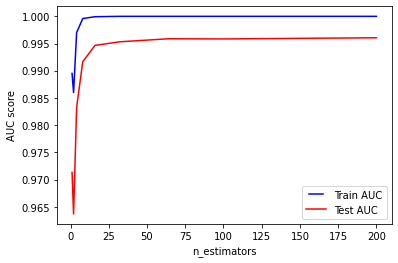

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Test max depth

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   print(max_depth)
   rf = RandomForestClassifier(max_depth=max_depth, max_features="sqrt", n_estimators = 50)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0


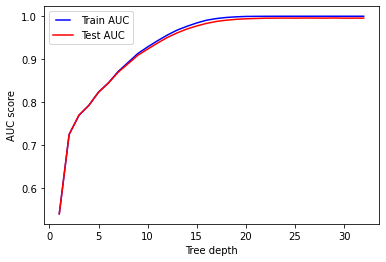

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

## Selected RF
From the previous we select settings for our selected RF

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=25, max_depth=14, max_features="sqrt")
# Train Decision Tree Classifer
rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

## Confusion matrix and classification report

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results) 
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Behaviour: rumination
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[83940   570]
 [ 2196 37410]]
Accuracy Score :  0.9777143962099971
Report : 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     84510
           1       0.98      0.94      0.96     39606

    accuracy                           0.98    124116
   macro avg       0.98      0.97      0.97    124116
weighted avg       0.98      0.98      0.98    124116



##Feature Importances

In [ ]:
# feature importance
model = rf
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01561
Feature: 1, Score: 0.04103
Feature: 2, Score: 0.09440
Feature: 3, Score: 0.07477
Feature: 4, Score: 0.06322
Feature: 5, Score: 0.03990
Feature: 6, Score: 0.05570
Feature: 7, Score: 0.06235
Feature: 8, Score: 0.03674
Feature: 9, Score: 0.04336
Feature: 10, Score: 0.05380
Feature: 11, Score: 0.04411
Feature: 12, Score: 0.01845
Feature: 13, Score: 0.01445
Feature: 14, Score: 0.01611
Feature: 15, Score: 0.03248
Feature: 16, Score: 0.05839
Feature: 17, Score: 0.11515
Feature: 18, Score: 0.02881
Feature: 19, Score: 0.08771
Feature: 20, Score: 0.00111
Feature: 21, Score: 0.00027
Feature: 22, Score: 0.00013
Feature: 23, Score: 0.00008
Feature: 24, Score: 0.00003
Feature: 25, Score: 0.00127
Feature: 26, Score: 0.00042
Feature: 27, Score: 0.00007
Feature: 28, Score: 0.00004
Feature: 29, Score: 0.00002


# Stratified cross validation rumination

In [ ]:
from sklearn.model_selection import StratifiedKFold
rf = RandomForestClassifier(n_estimators=25, max_depth=14, max_features="sqrt")
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
i=1

for train_index, test_index in skf.split(X_final, y_final):
  X_train, X_test = X_final[train_index], X_final[test_index]
  y_train, y_test = y_final[train_index], y_final[test_index]
  rf.fit(X_train,y_train)
# cross_validate also allows to specify metrics which you want to see
  print ("Windows size is "+ str(WIN_SIZE/2)+" seconds with overlap "+ str(WIN_OVERLAP/2)+ " seconds")
  print(confusion_matrix(y_test,rf.predict(X_test)))
  print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, rf.predict(X_test))}")
  print('Report : ')
  print(classification_report(y_test, rf.predict(X_test)))
  i += 1

Windows size is 120.0 seconds with overlap 0.5 seconds
[[55921   379]
 [ 1407 25037]]
Accuracy for the fold no. 1 on the test set: 0.978415353379097
Report : 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     56300
           1       0.99      0.95      0.97     26444

    accuracy                           0.98     82744
   macro avg       0.98      0.97      0.97     82744
weighted avg       0.98      0.98      0.98     82744

Windows size is 120.0 seconds with overlap 0.5 seconds
[[55946   355]
 [ 1256 25187]]
Accuracy for the fold no. 2 on the test set: 0.9805303103548294
Report : 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     56301
           1       0.99      0.95      0.97     26443

    accuracy                           0.98     82744
   macro avg       0.98      0.97      0.98     82744
weighted avg       0.98      0.98      0.98     82744

Windows size is 120.0 secon

# Leave-out-one-animal rumination

In [ ]:
# Choose cow to leave out 2.0; 13.0; 21.0; 84.0
COW_NUMBER= 84.0

In [ ]:
def choose_cow_to_leave_out(COW_NUMBER):
    result_train = np.stack(signal_features[signal_features[:,4] != COW_NUMBER], axis =0)
    result_test = np.stack(signal_features[signal_features[:,4] == COW_NUMBER], axis =0)
    return result_test, result_train

In [ ]:
result_test, result_train = choose_cow_to_leave_out(COW_NUMBER)

In [ ]:
#leave one cow out
y_train = np.stack(result_train[:,0], axis =0)
y_test = np.stack(result_test[:,0], axis =0)
X_train = np.stack(result_train[:,5], axis =0)
X_test = np.stack(result_test[:,5], axis =0)

##Selected RF

In [ ]:
rf = RandomForestClassifier(n_estimators=25, max_depth=14, max_features="sqrt")
rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

##Confusion matrix and classification report

In [ ]:
# Evaluation
print ("Evaluation RF validation with leave out cow_number "+ str(COW_NUMBER))
print("")
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results) 
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Evaluation RF validation with leave out cow_number 84.0

Behaviour: rumination
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[92392  3717]
 [ 7190 31758]]
Accuracy Score :  0.9192415054384445
Report : 
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     96109
           1       0.90      0.82      0.85     38948

    accuracy                           0.92    135057
   macro avg       0.91      0.89      0.90    135057
weighted avg       0.92      0.92      0.92    135057



# Random_forest_algorithm eating

In [ ]:
BEHAVIOUR='eating'

In [ ]:
y_final = np.stack(signal_features[:,0], axis =0) # BEHAVIOUR_1= 'rumination_video'

In [ ]:
# Split dataset into trainingsset (70%) and testset (30%)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=1)

## Test settings random_forest_algorithm

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   print(estimator)
   rf = RandomForestClassifier(n_estimators=estimator, max_features="sqrt")
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1
2
4
8
16
32
64
100
200


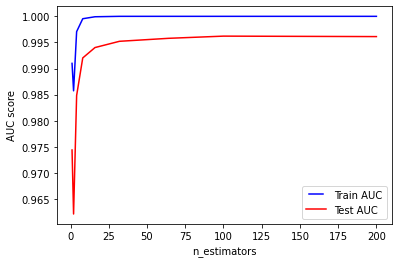

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Test max depth

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   print(max_depth)
   rf = RandomForestClassifier(max_depth=max_depth, max_features="sqrt", n_estimators = 50)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0


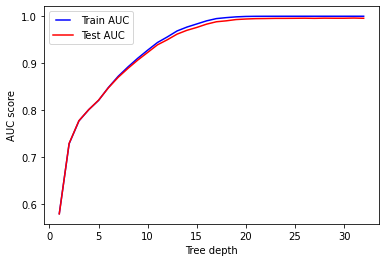

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

## Selected RF
From the previous we select settings for our selected RF

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=25, max_depth=14, max_features="sqrt")
# Train Decision Tree Classifer
rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

## Confusion matrix and classification report

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results) 
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

Behaviour: eating
Windows_size: 120.0 sec (with overlap: 0.5 sec)
Confusion Matrix Validation:
[[83899   611]
 [ 2148 37458]]
Accuracy Score :  0.9777707950626833
Report : 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     84510
           1       0.98      0.95      0.96     39606

    accuracy                           0.98    124116
   macro avg       0.98      0.97      0.97    124116
weighted avg       0.98      0.98      0.98    124116



##Feature importances

In [ ]:
# feature importance
model = rf
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01938
Feature: 1, Score: 0.04544
Feature: 2, Score: 0.07538
Feature: 3, Score: 0.07371
Feature: 4, Score: 0.06897
Feature: 5, Score: 0.03847
Feature: 6, Score: 0.06623
Feature: 7, Score: 0.05410
Feature: 8, Score: 0.03072
Feature: 9, Score: 0.04076
Feature: 10, Score: 0.05816
Feature: 11, Score: 0.04309
Feature: 12, Score: 0.01625
Feature: 13, Score: 0.01648
Feature: 14, Score: 0.01741
Feature: 15, Score: 0.03345
Feature: 16, Score: 0.06452
Feature: 17, Score: 0.10759
Feature: 18, Score: 0.02992
Feature: 19, Score: 0.09631
Feature: 20, Score: 0.00111
Feature: 21, Score: 0.00040
Feature: 22, Score: 0.00009
Feature: 23, Score: 0.00004
Feature: 24, Score: 0.00004
Feature: 25, Score: 0.00151
Feature: 26, Score: 0.00028
Feature: 27, Score: 0.00012
Feature: 28, Score: 0.00007
Feature: 29, Score: 0.00002


# Random_forest_algorithm drinking

In [ ]:
['BEHAVIOUR']=drinking

SyntaxError: ignored

In [ ]:
y_final = np.stack(signal_features[:,2], axis =0) # BEHAVIOUR_3= 'drinking_video'

In [ ]:
#Step needed otherwise we have 0,2 instead of 0,1 values
y_final = (y_final_int == 3).astype(int)

In [ ]:
bool_minority_labels  = y_final != 0

In [ ]:
min_features = X_final[bool_minority_labels]
maj_features = X_final[~bool_minority_labels]

min_labels = y_final[bool_minority_labels]
maj_labels = y_final[~bool_minority_labels]

Split the minority class in 70 30 to have more in train set

In [ ]:
# Split minority dataset into training set and test set
X_min_train, X_min_test, y_min_train, y_min_test = train_test_split(min_features, min_labels, test_size=0.3, random_state=1) # 70% training and 30% test

Split the majority class in 50 50 so we can sample from independant sets

In [ ]:
# Split minority dataset into training set and test set
X_maj_train, X_maj_test, y_maj_train, y_maj_test = train_test_split(maj_features, maj_labels, test_size=0.5, random_state=1) # 50% training and 50% test

## Create train set

Upsample the amount of minority features and labels 3 times (why 3, no idea, feels that this will create enough labels)

In [ ]:
upsampled_X_min_train = np.concatenate([X_min_train, X_min_train, X_min_train], axis=0)
upsampled_y_min_train = np.concatenate([y_min_train, y_min_train, y_min_train], axis=0)

Downsample from 50% of the majority class to have same amount of samples 

In [ ]:
ids = np.arange(len(X_maj_train))
choices = np.random.choice(ids, len(upsampled_X_min_train))

res_maj_train_features = X_maj_train[choices]
res_maj_train_labels = y_maj_train[choices]

res_maj_train_features.shape

Concat together

In [ ]:
resampled_train_features = np.concatenate([upsampled_X_min_train, res_maj_train_features], axis=0)
resampled_train_labels = np.concatenate([upsampled_y_min_train, res_maj_train_labels], axis=0)

Shuffle

In [ ]:
order = np.arange(len(resampled_train_labels))
np.random.shuffle(order)
resampled_train_features = resampled_train_features[order]
resampled_train_labels = resampled_train_labels[order]

## Create test set

We start from the X_min_test

And downsample the remaining part of the majority class which we didn't use so far

In [ ]:
ids = np.arange(len(X_maj_test))
choices = np.random.choice(ids, len(X_min_test))

res_maj_test_features = X_maj_test[choices]
res_maj_test_labels = y_maj_test[choices]


Concat

In [ ]:
resampled_test_features = np.concatenate([X_min_test, res_maj_test_features], axis=0)
resampled_test_labels = np.concatenate([y_min_test, res_maj_test_labels], axis=0)

Shuffle

In [ ]:
order = np.arange(len(resampled_test_labels))
np.random.shuffle(order)
resampled_test_features = resampled_test_features[order]
resampled_test_labels = resampled_test_labels[order]

In [ ]:
X_train= resampled_train_features
y_train= resampled_train_labels
X_test=  resampled_test_features
y_test=  resampled_test_labels 

## Test settings random_forest_algorithm

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   print(estimator)
   rf = RandomForestClassifier(n_estimators=estimator, max_features="sqrt")
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Test max depth

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   print(max_depth)
   rf = RandomForestClassifier(max_depth=max_depth, max_features="sqrt", n_estimators = 50)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

## Selected RF
From the previous we select settings for our selected RF

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=25, max_depth=12, max_features="sqrt")
# Train Decision Tree Classifer
rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

## Confusion matrix and classification report

In [ ]:
### Evaluation
print("Behaviour: "+ str(BEHAVIOUR))
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results) 
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

In [ ]:
# feature importance
model = rf
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# Random_forest_algorithm sleeping

In [ ]:
BEHAVIOUR='sleeping'

In [ ]:
y_final_int = np.stack(signal_features[:,3], axis =0) # BEHAVIOUR_4= 'sleeping_video'

In [ ]:
#Step needed otherwise we have 0,2 instead of 0,1 values
y_final = (y_final_int == 4).astype(int)

In [ ]:
bool_minority_labels  = y_final != 0

In [ ]:
min_features = X_final[bool_minority_labels]
maj_features = X_final[~bool_minority_labels]

min_labels = y_final[bool_minority_labels]
maj_labels = y_final[~bool_minority_labels]

Split the minority class in 70 30 to have more in train set

In [ ]:
# Split minority dataset into training set and test set
X_min_train, X_min_test, y_min_train, y_min_test = train_test_split(min_features, min_labels, test_size=0.3, random_state=1) # 70% training and 30% test

Split the majority class in 50 50 so we can sample from independant sets

In [ ]:
# Split minority dataset into training set and test set
X_maj_train, X_maj_test, y_maj_train, y_maj_test = train_test_split(maj_features, maj_labels, test_size=0.5, random_state=1) # 50% training and 50% test

## Create train set

Upsample the amount of minority features and labels 3 times (why 3, no idea, feels that this will create enough labels)

In [ ]:
upsampled_X_min_train = np.concatenate([X_min_train, X_min_train, X_min_train], axis=0)
upsampled_y_min_train = np.concatenate([y_min_train, y_min_train, y_min_train], axis=0)

Downsample from 50% of the majority class to have same amount of samples 

In [ ]:
ids = np.arange(len(X_maj_train))
choices = np.random.choice(ids, len(upsampled_X_min_train))

res_maj_train_features = X_maj_train[choices]
res_maj_train_labels = y_maj_train[choices]

res_maj_train_features.shape

Concat together

In [ ]:
resampled_train_features = np.concatenate([upsampled_X_min_train, res_maj_train_features], axis=0)
resampled_train_labels = np.concatenate([upsampled_y_min_train, res_maj_train_labels], axis=0)

Shuffle

In [ ]:
order = np.arange(len(resampled_train_labels))
np.random.shuffle(order)
resampled_train_features = resampled_train_features[order]
resampled_train_labels = resampled_train_labels[order]

## Create test set

We start from the X_min_test

And downsample the remaining part of the majority class which we didn't use so far

In [ ]:
ids = np.arange(len(X_maj_test))
choices = np.random.choice(ids, len(X_min_test))

res_maj_test_features = X_maj_test[choices]
res_maj_test_labels = y_maj_test[choices]


Concat

In [ ]:
resampled_test_features = np.concatenate([X_min_test, res_maj_test_features], axis=0)
resampled_test_labels = np.concatenate([y_min_test, res_maj_test_labels], axis=0)

Shuffle

In [ ]:
order = np.arange(len(resampled_test_labels))
np.random.shuffle(order)
resampled_test_features = resampled_test_features[order]
resampled_test_labels = resampled_test_labels[order]

In [ ]:
X_train= resampled_train_features
y_train= resampled_train_labels
X_test=  resampled_test_features
y_test=  resampled_test_labels 

## Test settings random_forest_algorithm

In [ ]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   print(estimator)
   rf = RandomForestClassifier(n_estimators=estimator, max_features="sqrt")
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Test max depth

In [ ]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   print(max_depth)
   rf = RandomForestClassifier(max_depth=max_depth, max_features="sqrt", n_estimators = 50)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

## Selected RF
From the previous we select settings for our selected RF

In [ ]:
# RF
rf = RandomForestClassifier(n_estimators = 25, max_depth=15, max_features="sqrt" )

# Train Decision Tree Classifer
rf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = rf.predict(X_test)

## Confusion matrix and classification report

In [ ]:
### Evaluation
print("Behaviour: sleeping")
print("Resampling: up and downsampling")
print ("Windows_size: " + str(WIN_SIZE/2) +" sec " "(with overlap: "+ str(WIN_OVERLAP/2)+ " sec)")

results = confusion_matrix(y_test,y_pred)

print('Confusion Matrix Validation:')
print(results) 
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print('Report : ')
print(classification_report(y_test, y_pred))

# Descriptives

## Counting data peak_detection algorithm

In [ ]:
final_data_peak_detection.count()

##Counting data random_forest algorithm

In [ ]:
final_data_rf.count()

## Number of observations video per behavior

In [ ]:
np.unique(final_data_peak_detection['behaviour'], return_counts=True)

## Number of observations video per animal

In [ ]:
np.unique(final_data_peak_detection['cow_number'], return_counts=True)

## Time between two contraction cycles

In [ ]:
final_data_rum= final_data_peak_detection[final_data_peak_detection.behaviour==1]
final_data_eat= final_data_peak_detection[final_data_peak_detection.behaviour==2]
final_data_drink= final_data_peak_detection[final_data_peak_detection.behaviour==3]
final_data_sleep= final_data_peak_detection[final_data_peak_detection.behaviour==4]
final_data_other= final_data_peak_detection[final_data_peak_detection.behaviour==5]

print("Time between contraction cycles during rumination:")
print("mean:"+str(final_data_rum['low_time'].mean()))
print("std:"+str(final_data_rum['low_time'].std())) 
print("median:"+str(final_data_rum['low_time'].median())) 
print("iqr:"+ str(iqr(final_data_rum['low_time']))+"\n")

print("Time between contraction cycles during eating:")
print("mean:"+str(final_data_eat['low_time'].mean()))
print("std:"+str(final_data_eat['low_time'].std())) 
print("median:"+str(final_data_eat['low_time'].median())) 
print("iqr:"+ str(iqr(final_data_eat['low_time']))+"\n")

print("Time between contraction cycles during drinking:")
print("mean:"+str(final_data_drink['low_time'].mean()))
print("std:"+str(final_data_drink['low_time'].std())) 
print("median:"+str(final_data_drink['low_time'].median())) 
print("iqr:"+ str(iqr(final_data_drink['low_time']))+"\n")

print("Time between contraction cycles during sleeping:")
print("mean:"+str(final_data_sleep['low_time'].mean()))
print("std:"+str(final_data_sleep['low_time'].std())) 
print("median:"+str(final_data_sleep['low_time'].median())) 
print("iqr:"+ str(iqr(final_data_sleep['low_time']))+"\n")

print("Time between contraction cycles during other behaviour:")
print("mean:"+str(final_data_other['low_time'].mean()))
print("std:"+str(final_data_other['low_time'].std())) 
print("median:"+str(final_data_other['low_time'].median())) 
print("iqr:"+ str(iqr(final_data_other['low_time']))+"\n")

## Boxplots of time between two contraction cycles

In [ ]:
sns.boxplot(x="behaviour", y="low_time",orient='v', data=final_data_peak_detection_corrected, showfliers=False)
plt.xlabel('Behaviour')
plt.ylabel('Time interval between contractions (s)')
plt.show()

## GLM model eating and rumination

In [ ]:
#create csv for GLM model
final_data_HK_EAT_REST = final_data_peak_detection_corrected[final_data_peak_detection_corrected.behaviour<3.0]
final_data_HK_EAT= final_data_HK_EAT_REST[final_data_peak_detection_corrected.behaviour>=1.0]
result_file='/content/gdrive/Shared drives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/final_data_HK_EAT.csv'
final_data_HK_EAT.to_csv(result_file)

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
url = ('/content/gdrive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectPicoLog/data/out/final_data_HK_EAT.csv')
dataset = read.csv(url)

In [ ]:
%%R
package_list <- c("dplyr",
                  "lme4"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(installed.packages()) == FALSE)
  {install.packages(pkg, dependencies = TRUE)}
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, character.only = TRUE)}
  print(citation(pkg))

}

In [ ]:
%%R
install.packages("lmerTest", dependencies = TRUE)
library ("lmerTest")

In [ ]:
%%R
gl<- glm('low_time ~ factor(behaviour)+factor(cow_number)', data = dataset, family = gaussian)
summary(gl)